In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import sidetable as stb
warnings.filterwarnings('ignore')

# Import Data

In [2]:
df = pd.read_csv('bank.csv')
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x) #Change Decimal
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
Desc = []

for i in df.columns:
    Desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = Desc,
            columns = [
                'Column',
                'DataType',
                'Null',
                'Null (%)',
                'nUnique',
                'Unique Samples'
            ])

,Column,DataType,Null,Null (%),nUnique,Unique Samples
0,RowNumber,int64,0,0.00,10000,"[5622, 3798]"
1,CustomerId,int64,0,0.00,10000,"[15792720, 15749401]"
2,Surname,object,0,0.00,2932,"[Teakle, Martinez]"
3,CreditScore,int64,0,0.00,460,"[672, 535]"
4,Geography,object,0,0.00,3,"[Spain, France]"
5,Gender,object,0,0.00,2,"[Male, Female]"
6,Age,int64,0,0.00,70,"[41, 67]"
7,Tenure,int64,0,0.00,11,"[3, 9]"
8,Balance,float64,0,0.00,6382,"[100359.54, 83325.77]"
9,NumOfProducts,int64,0,0.00,4,"[3, 4]"


### No Missing Value

In [5]:
df_1 = df.copy()

In [6]:
# Remove RowNumber and Surname and CustomerId
df_1.drop(columns = ['RowNumber','Surname', 'CustomerId'], inplace = True)

In [7]:
### One Hot Encoding Column fuel, seller_type, transmission (don't have levelling)
df_1 =  pd.get_dummies(data=df_1, columns=['Geography', 'Gender'])

In [8]:
df_1.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


## Checking Data 

In [9]:
df_1['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#### Data Imbalanced

In [10]:
pd.crosstab(index=df_1['Exited'], columns='count', normalize=True)*100

col_0,count
Exited,
0,79.63
1,20.37


0: Not Exited
1: Exited
From the Dataset given, Classification Machine Learning are required to be made
Because the dataset is about Bank Churn, In this Project the focus is on Recall(1) or False Negative

The cost of acquiring new customers is estimated at five times the rate of retaining existing ones\
    - Source : https://www.fpsc.com/the_cost_of_customer_churn.pdf

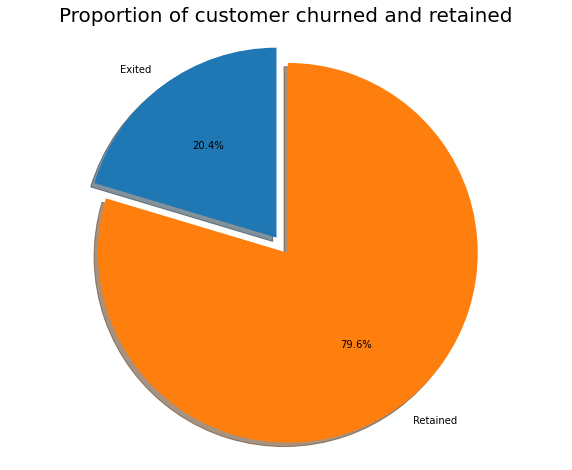

In [78]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

# Data Preparation

In [11]:
df_1.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [12]:
Desc = []

for i in df.columns:
    Desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = Desc,
            columns = [
                'Column',
                'DataType',
                'Null',
                'Null (%)',
                'nUnique',
                'Unique Samples'
            ])

,Column,DataType,Null,Null (%),nUnique,Unique Samples
0,RowNumber,int64,0,0.00,10000,"[8330, 2099]"
1,CustomerId,int64,0,0.00,10000,"[15587133, 15658475]"
2,Surname,object,0,0.00,2932,"[Chiemenam, Salmond]"
3,CreditScore,int64,0,0.00,460,"[746, 426]"
4,Geography,object,0,0.00,3,"[Spain, Germany]"
5,Gender,object,0,0.00,2,"[Female, Male]"
6,Age,int64,0,0.00,70,"[70, 30]"
7,Tenure,int64,0,0.00,11,"[8, 4]"
8,Balance,float64,0,0.00,6382,"[221532.8, 44020.89]"
9,NumOfProducts,int64,0,0.00,4,"[4, 3]"


## Splitting Data

In [13]:
X = df_1.drop(columns='Exited')
y = df_1['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

## Machine Learning Modelling

#### Logistic Regression

In [14]:
LR = LogisticRegression()

In [15]:
LR.fit(X_train, y_train)

LogisticRegression()

In [19]:
y_pred_LR = LR.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      2003
           1       0.48      0.08      0.14       497

    accuracy                           0.80      2500
   macro avg       0.65      0.53      0.52      2500
weighted avg       0.75      0.80      0.74      2500



In [21]:
cm_LR = confusion_matrix(y_test, y_pred_LR)
df_cm_LR = pd.DataFrame(cm_LR, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_LR

,Pred 1,Pred 0
Akt 1,1958,45
Akt 0,455,42


#### K-Nearest Neighbours

In [22]:
KNN = KNeighborsClassifier()

In [23]:
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
y_pred_KNN_Train = KNN.predict(X_train)
y_pred_KNN = KNN.predict(X_test)

In [42]:
print(classification_report(y_train, y_pred_KNN_Train))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      5960
           1       0.65      0.22      0.33      1540

    accuracy                           0.82      7500
   macro avg       0.74      0.60      0.61      7500
weighted avg       0.79      0.82      0.78      7500



In [43]:
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2003
           1       0.27      0.09      0.14       497

    accuracy                           0.77      2500
   macro avg       0.54      0.51      0.50      2500
weighted avg       0.70      0.77      0.72      2500



In [44]:
cm_KNN = confusion_matrix(y_test, y_pred_KNN)
df_cm_KNN = pd.DataFrame(cm_KNN, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_KNN

,Pred 1,Pred 0
Akt 1,1873,130
Akt 0,450,47


#### Random Forest

In [45]:
RF_Base = RandomForestClassifier()

In [57]:
RF_Base.fit(X_train, y_train)

RandomForestClassifier()

In [58]:
y_pred_RF_Train = RF_Base.predict(X_train)
y_pred_RF_Base = RF_Base.predict(X_test)

In [59]:
print(classification_report(y_train, y_pred_RF_Train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5960
           1       1.00      1.00      1.00      1540

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



In [60]:
print(classification_report(y_test, y_pred_RF_Base))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2003
           1       0.78      0.47      0.59       497

    accuracy                           0.87      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.86      0.87      0.86      2500



In [61]:
cm_RF_Base = confusion_matrix(y_test, y_pred_RF_Base)
df_cm_RF_Base = pd.DataFrame(cm_RF_Base, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_RF_Base

,Pred 1,Pred 0
Akt 1,1938,65
Akt 0,264,233


#### XGBoost

In [62]:
XGB_Base = XGBClassifier()

In [63]:
XGB_Base.fit(X_train, y_train)

[18:32:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
y_pred_XGB_Train = XGB_Base.predict(X_train)
y_pred_XGB_Base = XGB_Base.predict(X_test)

In [66]:
print(classification_report(y_train, y_pred_XGB_Train))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5960
           1       0.97      0.79      0.87      1540

    accuracy                           0.95      7500
   macro avg       0.96      0.89      0.92      7500
weighted avg       0.95      0.95      0.95      7500



In [67]:
print(classification_report(y_test, y_pred_XGB_Base))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2003
           1       0.73      0.50      0.59       497

    accuracy                           0.86      2500
   macro avg       0.81      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



In [68]:
cm_XGB_Base = confusion_matrix(y_test, y_pred_XGB_Base)
df_cm_XGB_Base = pd.DataFrame(cm_XGB_Base, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_XGB_Base

,Pred 1,Pred 0
Akt 1,1912,91
Akt 0,248,249


### Hyperparameter Tuning

#### Logistic Regression

In [69]:
param_LR = {
    'penalty' : ['none', 'l1', 'l2'],
    'C' : np.logspace(-4 , 4, 14),
    'class_weight' : [{0 : x, 1 : 1 - x} for x in [.05,.1,.15, .2,]]
}

In [70]:
LR_HT = LogisticRegression()
skf = StratifiedKFold(n_splits = 3, random_state = 42)
LR_GS = GridSearchCV(LR_HT, param_LR, cv=skf, n_jobs = -1, verbose = 1, scoring = 'recall')
LR_GS.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 489 out of 504 | elapsed:   11.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   11.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 4.12462638e-04, 1.70125428e-03, 7.01703829e-03,
       2.89426612e-02, 1.19377664e-01, 4.92388263e-01, 2.03091762e+00,
       8.37677640e+00, 3.45510729e+01, 1.42510267e+02, 5.87801607e+02,
       2.42446202e+03, 1.00000000e+04]),
                         'class_weight': [{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.2, 1: 0.8}],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall', verbose=1)

In [71]:
LR_GS.best_params_

{'C': 0.0001, 'class_weight': {0: 0.05, 1: 0.95}, 'penalty': 'l2'}

In [72]:
LR_GS_Tuned = LR_GS.best_estimator_

In [73]:
y_pred_LR_Tuned = LR_GS_Tuned.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred_LR_Tuned))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2003
           1       0.20      1.00      0.33       497

    accuracy                           0.20      2500
   macro avg       0.60      0.50      0.17      2500
weighted avg       0.84      0.20      0.07      2500



In [75]:
cm_LR_Tuned = confusion_matrix(y_test, y_pred_LR_Tuned, labels = [1, 0])
df_cm_LR_Tuned = pd.DataFrame(cm_LR_Tuned, index = ['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_LR_Tuned

,Pred 1,Pred 0
Akt 1,497,0
Akt 0,1998,5


#### Random Forest

In [76]:
param_RF = {
    "n_estimators" : np.arange(100, 10000, 100),
    "max_depth" : [None, 5, 10, 25, 30, 40, 50, 60, 80, 95, 100],
    "min_samples_leaf" :np.arange(1,101),
    "max_features" : ['auto', 0.3, 0.5, 0.8],
    "class_weight" : [{0:x, 1: 1 - x} for x in [.1, .20, .35, .40]]
}

In [77]:
RF_HT = RandomForestClassifier(random_state = 42)
RF_RS = RandomizedSearchCV(RF_HT, param_RF, cv = 3, n_jobs = -1, verbose=1, scoring = 'recall')
RF_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 0.1, 1: 0.9},
                                                         {0: 0.2, 1: 0.8},
                                                         {0: 0.35, 1: 0.65},
                                                         {0: 0.4, 1: 0.6}],
                                        'max_depth': [None, 5, 10, 25, 30, 40,
                                                      50, 60, 80, 95, 100],
                                        'max_features': ['auto', 0.3, 0.5, 0.8],
                                        'min_samples_leaf': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23...
       3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
       4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500,
       5600, 5700,

In [57]:
RF_RS.best_params_

{'n_estimators': 3000,
 'min_samples_leaf': 77,
 'max_features': 0.5,
 'max_depth': 25,
 'class_weight': {0: 0.2, 1: 0.8}}

In [58]:
Model_RF_Tuned = RF_RS.best_estimator_

In [59]:
y_pred_RF_Tuned = Model_RF_Tuned.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred_RF_Tuned))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2003
           1       0.46      0.77      0.58       497

    accuracy                           0.78      2500
   macro avg       0.70      0.77      0.71      2500
weighted avg       0.84      0.78      0.79      2500



In [61]:
cm_RF_Tuned = confusion_matrix(y_test, y_pred_RF_Tuned, labels=[1,  0])
df_cm_RF_Tuned = pd.DataFrame(cm_RF_Tuned, index =['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_RF_Tuned

,Pred 1,Pred 0
Akt 1,381,116
Akt 0,441,1562


#### XGBoost

In [65]:
param_XGB = {
    'algo__n_estimators' : np.arange(100, 8000, 100),
    'algo__learning_rate' : [None, 0.1, 0.3, 0.5, 0.8, 1],
    'algo__max_depth' : np.arange(1, 50, 5),  
    'scale_pos_weight' : [0.99]
}

In [66]:
XGB_HT = XGBClassifier(random_state = 42)
skf = StratifiedKFold(n_splits = 3, random_state = 42)
XGB_RS = RandomizedSearchCV(XGB_HT, param_XGB, cv = skf, n_jobs = -1, verbose = 1, scoring = 'recall')
XGB_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.3s finished


[00:37:07] WARNING: ..\src\learner.cc:573: 
Parameters: { "algo__learning_rate", "algo__max_depth", "algo__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:37:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None...
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300,
       3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
       4500, 4600, 4700, 4800, 4900, 5000, 5100, 

In [67]:
XGB_RS.best_params_

{'scale_pos_weight': 0.99,
 'algo__n_estimators': 500,
 'algo__max_depth': 11,
 'algo__learning_rate': 0.5}

In [68]:
Model_XGB_Tuned = XGB_RS.best_estimator_

In [72]:
y_pred_XGB_Tuned = Model_XGB_Tuned.predict(X_test)

In [73]:
print(classification_report(y_test, y_pred_XGB_Tuned))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2003
           1       0.72      0.48      0.58       497

    accuracy                           0.86      2500
   macro avg       0.80      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



In [74]:
cm_XGB_Tuned = confusion_matrix(y_test, y_pred_XGB_Tuned, labels= [1,0])
df_cm_XGB_Tuned = pd.DataFrame(cm_XGB_Tuned, index = ['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_cm_XGB_Tuned

,Pred 1,Pred 0
Akt 1,239,258
Akt 0,94,1909


# Conclusion

- Random Forest Base is the best model with Recall Score 0.97, False Negative of 66 and False Positive of 266

# Simulation

- Create a customer retention program, for customers who are predicted to churn
    - for example: Giving 1 Honda Beat (with value of IDR 18.000.000) for customers who are predicted will Churn with 3 years contract agreement.
    
    - It is known that the cost of acquiring new customers is estimated at five times the rate of retaining existing customer.
        - Simple calculation are made that, to retain existing customer cost IDR 18.000.000, to acquire/lose 1 customers costs IDR 90.000.000


# Calculation Using Model - Business Loss 

- The Model chosen is Random Forest:
    - Recall Score = 0.97
    - False Negative = 66
    - False Positive = 266

Assumed as above to calculate Business Loss there's 2 Ways:

- False Positive (Customer predicted to Churn, but they do Not)
IDR 18.000.000 * 266 = IDR 4.788.000.000

- False Negative (Customer predicted not to Churn, but they Churn)
IDR 90.000.000 * 66 = IDR 5.940.000.000

- Total Business Loss by using this Model = IDR 10.728.000.000

This Model has the lowest loss of Money compared to others